In [2]:
# load necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# folium for viualizing geospatial data
import folium
from folium import plugins
# the following sklearn packages used to cnvert collection of text documents to a matrix of token counts
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


## Load the Data ##

In [3]:

listings = pd.read_csv ('airbnb/listings.csv');
reviews = pd.read_csv ('airbnb/reviews.csv');
calendar = pd.read_csv ('airbnb/calendar.csv');

'''
Listings, including full descriptions and average review score
Reviews, including unique id for each reviewer and detailed comments
Calendar, including listing id and the price and availability for that day

'''

'\nListings, including full descriptions and average review score\nReviews, including unique id for each reviewer and detailed comments\nCalendar, including listing id and the price and availability for that day\n\n'

## Basic exploration ##

In [4]:
listings.shape
# there are 3818 listings in the data set, with 92 features

(3818, 92)

In [5]:
listings.head()

id                           listing_url       scrape_id last_scraped  \
0   241032   https://www.airbnb.com/rooms/241032  20160104002432   2016-01-04   
1   953595   https://www.airbnb.com/rooms/953595  20160104002432   2016-01-04   
2  3308979  https://www.airbnb.com/rooms/3308979  20160104002432   2016-01-04   
3  7421966  https://www.airbnb.com/rooms/7421966  20160104002432   2016-01-04   
4   278830   https://www.airbnb.com/rooms/278830  20160104002432   2016-01-04   

                                  name  \
0         Stylish Queen Anne Apartment   
1   Bright & Airy Queen Anne Apartment   
2  New Modern House-Amazing water view   
3                   Queen Anne Chateau   
4       Charming craftsman 3 bdm house   

                                             summary  \
0                                                NaN   
1  Chemically sensitive? We've removed the irrita...   
2  New modern house built in 2013.  Spectacular s...   
3  A charming apartment that sits atop Queen Anne...   
4  Cozy family craftman house in beautiful neighb...   

                                               space  \
0  Make your self at home in this charming one-be...   
1  Beautiful, hypoallergenic apartment in an extr...   
2  Our house is modern, light and fresh with a wa...   
3                                                NaN   
4  Cozy family craftman house in beautiful neighb...   

                                         description experiences_offered  \
0  Make your self at home in this charming one-be...                none   
1  Chemically sensitive? We've removed the irrita...                none   
2  New modern house built in 2013.  Spectacular s...                none   
3  A charming apartment that sits atop Queen Anne...                none   
4  Cozy family craftman house in beautiful neighb...                none   

                               neighborhood_overview  ... review_scores_value  \
0                                                NaN  ...                10.0   
1  Queen Anne is a wonderful, truly functional vi...  ...                10.0   
2  Upper Queen Anne is a charming neighborhood fu...  ...                10.0   
3                                                NaN  ...                 NaN   
4  We are in the beautiful neighborhood of Queen ...  ...                 9.0   

  requires_license license jurisdiction_names instant_bookable  \
0                f     NaN         WASHINGTON                f   
1                f     NaN         WASHINGTON                f   
2                f     NaN         WASHINGTON                f   
3                f     NaN         WASHINGTON                f   
4                f     NaN         WASHINGTON                f   

  cancellation_policy  require_guest_profile_picture  \
0            moderate                              f   
1              strict                              t   
2              strict                              f   
3            flexible                              f   
4              strict                              f   

  require_guest_phone_verification calculated_host_listings_count  \
0                                f                              2   
1                                t                              6   
2                                f                              2   
3                                f                              1   
4                                f                              1   

  reviews_per_month  
0              4.07  
1              1.48  
2              1.15  
3               NaN  
4              0.89  

[5 rows x 92 columns]

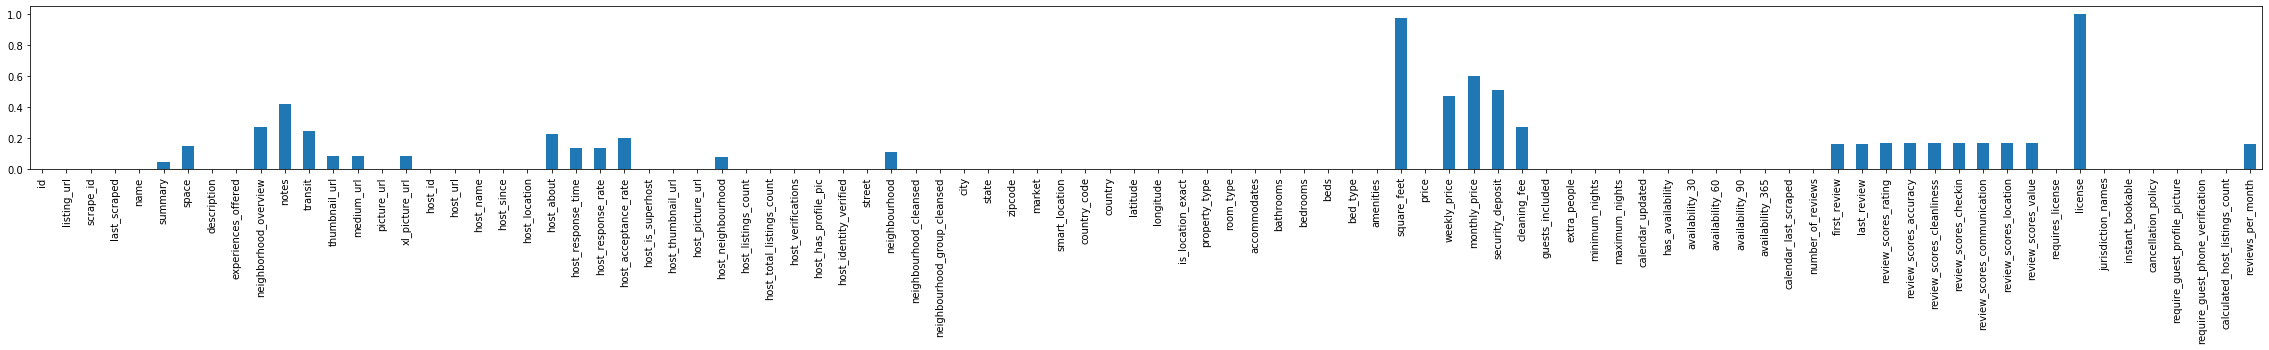

In [7]:
# get percenatage of missing values in listings dataframe
%matplotlib inline
listings.isnull().mean().plot.bar(figsize=(40,3));

In [8]:
# from the above cell, we see that some of the column values are missing
# here we list the columns with most missing values
most_missing_cols = set(listings.columns[listings.isnull().mean() > 0.75])
most_missing_cols

{'license', 'square_feet'}

In [9]:
## lets also see what the other DFs look like
calendar.shape

(1393570, 4)

In [10]:
## calendar holds avaliablity and price information for each of listings for entire year
calendar.head()

listing_id        date available   price
0      241032  2016-01-04         t  $85.00
1      241032  2016-01-05         t  $85.00
2      241032  2016-01-06         f     NaN
3      241032  2016-01-07         f     NaN
4      241032  2016-01-08         f     NaN

In [11]:
reviews.shape

(84849, 6)

In [12]:
## reviews hodls the reviews (comments and their names) and reviews dates for different listings
reviews.head()

listing_id        id        date  reviewer_id reviewer_name  \
0     7202016  38917982  2015-07-19     28943674        Bianca   
1     7202016  39087409  2015-07-20     32440555         Frank   
2     7202016  39820030  2015-07-26     37722850           Ian   
3     7202016  40813543  2015-08-02     33671805        George   
4     7202016  41986501  2015-08-10     34959538          Ming   

                                            comments  
0  Cute and cozy place. Perfect location to every...  
1  Kelly has a great room in a very central locat...  
2  Very spacious apartment, and in a great neighb...  
3  Close to Seattle Center and all it has to offe...  
4  Kelly was a great host and very accommodating ...

## After these initial glimpse of the dataset, we like to answer the following questions:
#### 1. How the listing prices are distributed?
#### 2. Which months are priciest ?
#### 3. Which months are the busiest to visit Seattle? Does busy month also means expensive?
#### 4. What is the distribution of the listings in the city borders? are they evenly distribued or concentrated in few neighbourhoods?
#### 5. What can be said about the vibe of the neighbourhoods based on reviews?

## 1. Distribution of listing prices

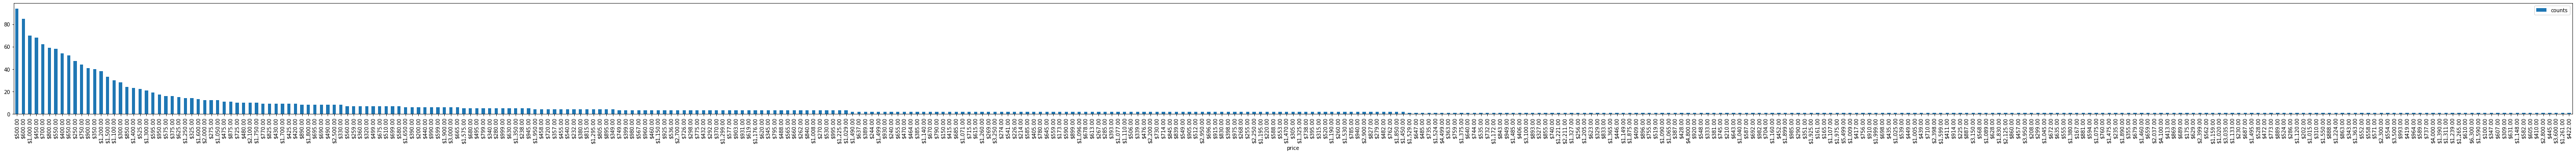

In [13]:
## to see the distribution of listing prices, we look at price related column in the listing df
## in particular, we look at weekly price column and prepare a bar plot of value counts 
weekly_price = listings['weekly_price'].value_counts().rename_axis('price').reset_index(name='counts')
weekly_price.plot(kind = 'bar', x='price', y='counts', figsize=(90,4))

In [14]:
# we can see from the above plot that some prices are more frequent and the range of prices is very larg
# to better visualize the distribution of prices, we can draw a histogram of the weekly price distribution
weekly_price['price'] = weekly_price['price'].replace('[\$,]', '', regex=True).astype(float) # change prices to float type
#weekly_price = weekly_price.sort_values(by=['price'], ascending=True)
print('minimum weekly price ($): ', weekly_price['price'].min())
print('maximum weekly price ($): ', weekly_price['price'].max())
weekly_price.head()

minimum weekly price ($):  100.0
maximum weekly price ($):  6300.0


price  counts
0   500.0      94
1   600.0      85
2  1000.0      70
3   450.0      68
4   700.0      62

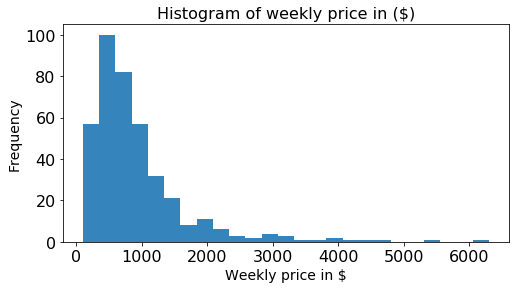

In [15]:
## Plot histogram of weekly prices
bins=list(range(0, 6400, 50))
#print(bins)
ax = weekly_price['price'].plot.hist(by = 'price', bins=25, alpha=0.9, figsize=(8,4))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Weekly price in $', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.title("Histogram of weekly price in ($)", fontsize = 16);

In [87]:
# we can conclude that most of the mass of the distribuiton is in the range of $100 - $1000 and the distribution has a long right-tail

## Which months are priciest ?

In [16]:
# to answer these questions, we use the calendar dataframe
print(calendar.shape)
calendar.head()

(1393570, 4)


listing_id        date available   price
0      241032  2016-01-04         t  $85.00
1      241032  2016-01-05         t  $85.00
2      241032  2016-01-06         f     NaN
3      241032  2016-01-07         f     NaN
4      241032  2016-01-08         f     NaN

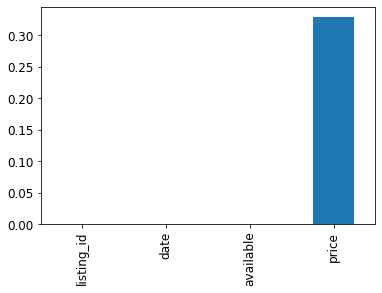

In [17]:
#get percenatage of missing values in listings dataframe
%matplotlib inline
calendar.isnull().mean().plot.bar(figsize=(6,4), fontsize = 12);

In [18]:
## we can see that about 30% of the listings do not have daily price information for a specific date
## to continue our anlalysis of expensive months, we first drop the rows with missing price information
calendar = calendar[calendar['price'].notna()]
calendar.head()

listing_id        date available   price
0       241032  2016-01-04         t  $85.00
1       241032  2016-01-05         t  $85.00
9       241032  2016-01-13         t  $85.00
10      241032  2016-01-14         t  $85.00
14      241032  2016-01-18         t  $85.00

In [19]:
# here we do further preparatio of the dataset
# first extract the month from date column
# the change the price to float (remove $)
# then changing availability from t / f to 1 / 0 for ease of analysis
calendar['month'] = pd.DatetimeIndex(calendar['date']).month
calendar['price'] = calendar['price'].replace('[\$,]', '', regex=True).astype(float)
calendar['available'].replace({'f': 0, 't': 1}, inplace=True)
calendar.head()

listing_id        date  available  price  month
0       241032  2016-01-04          1   85.0      1
1       241032  2016-01-05          1   85.0      1
9       241032  2016-01-13          1   85.0      1
10      241032  2016-01-14          1   85.0      1
14      241032  2016-01-18          1   85.0      1

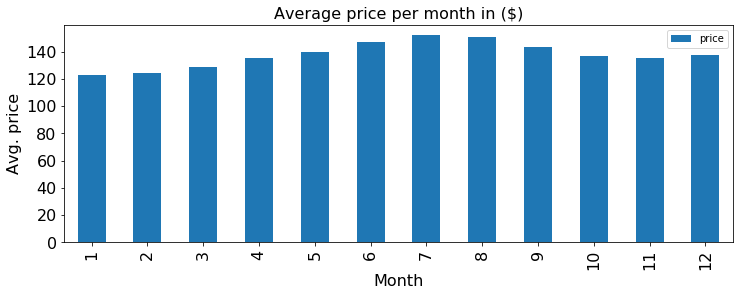

In [20]:
# to get the average prices by month, we group the average of the price by month
price_by_month = calendar.groupby('month', as_index=False)['price'].mean()
price_by_month.plot.bar(x='month', y = 'price', figsize=(12,4));
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Month', fontsize = 16)
plt.ylabel('Avg. price', fontsize = 16)
plt.title("Average price per month in ($)", fontsize = 16);

In [97]:
## We can see that month 7 (July) is most expensive, followed closely by June and August.
## It is inline with most people taking time-off in summer 

## 3. Which months are the busiest to visit Seattle? Does busy month also means expensive?

In [21]:
## Here, we make also use of the reviews dataset
print(reviews.shape)
reviews.head()

(84849, 6)


listing_id        id        date  reviewer_id reviewer_name  \
0     7202016  38917982  2015-07-19     28943674        Bianca   
1     7202016  39087409  2015-07-20     32440555         Frank   
2     7202016  39820030  2015-07-26     37722850           Ian   
3     7202016  40813543  2015-08-02     33671805        George   
4     7202016  41986501  2015-08-10     34959538          Ming   

                                            comments  
0  Cute and cozy place. Perfect location to every...  
1  Kelly has a great room in a very central locat...  
2  Very spacious apartment, and in a great neighb...  
3  Close to Seattle Center and all it has to offe...  
4  Kelly was a great host and very accommodating ...

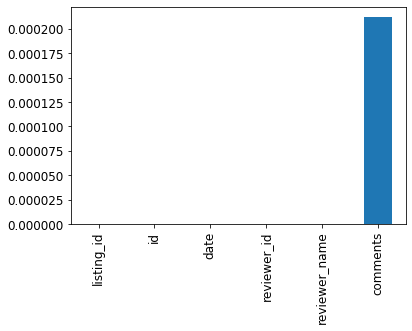

In [22]:
#get percenatage of missing values in listings dataframe
%matplotlib inline
reviews.isnull().mean().plot.bar(figsize=(6,4), fontsize = 12);

In [23]:
## we can see some of the comments are missing
## to continue our anlalysis, we first drop the rows with missing comments
## then add month information by extracting from date column
reviews = reviews[reviews['comments'].notna()]
reviews['month'] = pd.DatetimeIndex(reviews['date']).month
reviews.head()

listing_id        id        date  reviewer_id reviewer_name  \
0     7202016  38917982  2015-07-19     28943674        Bianca   
1     7202016  39087409  2015-07-20     32440555         Frank   
2     7202016  39820030  2015-07-26     37722850           Ian   
3     7202016  40813543  2015-08-02     33671805        George   
4     7202016  41986501  2015-08-10     34959538          Ming   

                                            comments  month  
0  Cute and cozy place. Perfect location to every...      7  
1  Kelly has a great room in a very central locat...      7  
2  Very spacious apartment, and in a great neighb...      7  
3  Close to Seattle Center and all it has to offe...      8  
4  Kelly was a great host and very accommodating ...      8

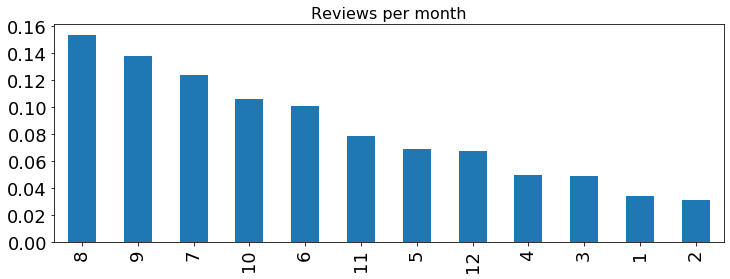

In [24]:
# number of reviews per month
reviews_per_month = reviews['month'].value_counts()
(reviews_per_month/reviews.shape[0]).plot(kind="bar", figsize=(12,4));
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Reviews per month", fontsize = 16);

In [106]:
# we can see that August is the busiest month (about 15% of reviews are made in August)
# Based on the above analysis, July is the most expensive month, followed closely by August
# We can see the connection between the most expensive and most busy (indicated by the reviews received) months 

## 4. What is the distribution of the listings in the city borders? are they evenly distribued or concentrated in few neighbourhoods?


In [25]:
# To answer these questions, we look once again to listings dataframe
listings.head()

id                           listing_url       scrape_id last_scraped  \
0   241032   https://www.airbnb.com/rooms/241032  20160104002432   2016-01-04   
1   953595   https://www.airbnb.com/rooms/953595  20160104002432   2016-01-04   
2  3308979  https://www.airbnb.com/rooms/3308979  20160104002432   2016-01-04   
3  7421966  https://www.airbnb.com/rooms/7421966  20160104002432   2016-01-04   
4   278830   https://www.airbnb.com/rooms/278830  20160104002432   2016-01-04   

                                  name  \
0         Stylish Queen Anne Apartment   
1   Bright & Airy Queen Anne Apartment   
2  New Modern House-Amazing water view   
3                   Queen Anne Chateau   
4       Charming craftsman 3 bdm house   

                                             summary  \
0                                                NaN   
1  Chemically sensitive? We've removed the irrita...   
2  New modern house built in 2013.  Spectacular s...   
3  A charming apartment that sits atop Queen Anne...   
4  Cozy family craftman house in beautiful neighb...   

                                               space  \
0  Make your self at home in this charming one-be...   
1  Beautiful, hypoallergenic apartment in an extr...   
2  Our house is modern, light and fresh with a wa...   
3                                                NaN   
4  Cozy family craftman house in beautiful neighb...   

                                         description experiences_offered  \
0  Make your self at home in this charming one-be...                none   
1  Chemically sensitive? We've removed the irrita...                none   
2  New modern house built in 2013.  Spectacular s...                none   
3  A charming apartment that sits atop Queen Anne...                none   
4  Cozy family craftman house in beautiful neighb...                none   

                               neighborhood_overview  ... review_scores_value  \
0                                                NaN  ...                10.0   
1  Queen Anne is a wonderful, truly functional vi...  ...                10.0   
2  Upper Queen Anne is a charming neighborhood fu...  ...                10.0   
3                                                NaN  ...                 NaN   
4  We are in the beautiful neighborhood of Queen ...  ...                 9.0   

  requires_license license jurisdiction_names instant_bookable  \
0                f     NaN         WASHINGTON                f   
1                f     NaN         WASHINGTON                f   
2                f     NaN         WASHINGTON                f   
3                f     NaN         WASHINGTON                f   
4                f     NaN         WASHINGTON                f   

  cancellation_policy  require_guest_profile_picture  \
0            moderate                              f   
1              strict                              t   
2              strict                              f   
3            flexible                              f   
4              strict                              f   

  require_guest_phone_verification calculated_host_listings_count  \
0                                f                              2   
1                                t                              6   
2                                f                              2   
3                                f                              1   
4                                f                              1   

  reviews_per_month  
0              4.07  
1              1.48  
2              1.15  
3               NaN  
4              0.89  

[5 rows x 92 columns]

In [47]:
## one of the columns with neighbourhood information is the 'neighbourhood_cleansed' column
area_counts = listings['neighbourhood_cleansed'].value_counts().rename_axis('name').reset_index(name='counts')
for i in range(area_counts['name'].shape[0]):
    print (area_counts['name'][i])

Broadway
Belltown
Wallingford
Fremont
Minor
University District
Stevens
First Hill
Central Business District
Lower Queen Anne
Greenwood
East Queen Anne
North Beacon Hill
Phinney Ridge
Adams
Ravenna
Mann
West Queen Anne
West Woodland
Columbia City
North Queen Anne
Green Lake
Leschi
Atlantic
Loyal Heights
Mount Baker
North Admiral
Madrona
Eastlake
Seward Park
Alki
Maple Leaf
Genesee
North Delridge
Roosevelt
Lawton Park
Mid-Beacon Hill
Bryant
Fairmount Park
Pike-Market
South Lake Union
Whittier Heights
Pioneer Square
Gatewood
Crown Hill
Dunlap
Matthews Beach
Montlake
North College Park
Rainier Beach
Sunset Hill
Wedgwood
Madison Park
Westlake
Southeast Magnolia
Broadview
Yesler Terrace
International District
Olympic Hills
Victory Heights
Haller Lake
Briarcliff
Harrison/Denny-Blaine
High Point
Portage Bay
North Beach/Blue Ridge
Bitter Lake
Brighton
Seaview
South Delridge
Interbay
Highland Park
Laurelhurst
Fauntleroy
Windermere
Meadowbrook
Cedar Park
Georgetown
Riverview
View Ridge
Holly Par

In [110]:
## We can see that, there are 87 neighbourhoods and Broadway, Belltown and Wallingford are the top three areas for listings

In [27]:
## To visualize, the most common listings neighbourhood, we can use latitude and longitude columns 
listing_coordinates = listings[['latitude', 'longitude']]
listing_coordinates.values

array([[  47.63628904, -122.3710252 ],
       [  47.63912312, -122.36566646],
       [  47.62972413, -122.36948318],
       ...,
       [  47.50845297, -122.24060703],
       [  47.63233495, -122.27553032],
       [  47.6411863 , -122.34208458]])

In [40]:
## We can use folium library to plot an interactive heatmap based on the location coordinates we get from listings dataframe
from folium import plugins
m = folium.Map([47.608013 , -122.335167], zoom_start=14) # initialize the map with Seattle coordinates
location_array = listing_coordinates.values
# plot heatmap
m.add_child(plugins.HeatMap(location_array, radius=20))
m

In [119]:
## We can clearly see that most of the listings are concetrated in central areas (Broadway) and Belltown.

## 5. What can be said aboud the vibe of the neighbourhoods based on reviews?

In [29]:
## We continue our analysis using listings df, in particular the neighbourhood_overview and neighbourhood_cleansed columns
df = listings[['neighborhood_overview', 'neighbourhood_cleansed']]
df = df.dropna()
df.head()

neighborhood_overview neighbourhood_cleansed
1  Queen Anne is a wonderful, truly functional vi...        West Queen Anne
2  Upper Queen Anne is a charming neighborhood fu...        West Queen Anne
4  We are in the beautiful neighborhood of Queen ...        West Queen Anne
5  This part of Queen Anne has wonderful views an...        West Queen Anne
6  Close restaurants, coffee shops and grocery st...        West Queen Anne

In [30]:
## lets have a look at some random neighbourhood overviews
print('first overview:  ', df['neighborhood_overview'].values[0])
print('second overview:  ', df['neighborhood_overview'].values[100])
print('third overview:  ', df['neighborhood_overview'].values[500])

first overview:   Queen Anne is a wonderful, truly functional village.  You can walk everywhere... for coffee, for groceries, for a night out, for breathtaking views of the Puget Sound.
second overview:   Ballard is an old Norwegian fishing village 6 miles north of Downtown.  Just a short walk away is Market street and old Ballard with it's great Sunday Farmers Market and all it's shops, restaurants and nightlife.  The Locks and Dam, fish ladder, Norwegian Heritage Center as well as Golden Gardens Beach access is just a short walk away.   On 24th Avenue and 58th street is Scooter's probably the best burger stand you will ever eat at.  Double Cheese burger with grilled onions and fried mushrooms is my go to! Near market and 20th Ave is a great dive bar Golden City which also happens to be a great place for Chinese and better yet THEY DELIVER!
third overview:   Walking distance to shopping, food, drinks and parks. Less than a mile from Capitol Hill. Markets 2 blocks to farmers maket (Fri

In [31]:
## we prepare a df based on neighbourhood overview descriptons and analyse the common words/phrases
## the common / frequent words can give us an indication of the vibe of the neighbourhood
overview = pd.DataFrame(columns = ['description', 'common_words']) # prepare the dataframe
overview['description'] = df.groupby('neighbourhood_cleansed', as_index=True)['neighborhood_overview'].sum()
overview['name'] = overview.index
overview.fillna('', inplace=True)
overview.head()

description  \
neighbourhood_cleansed                                                      
Adams                   Walk score: 90. Nuff said.Ballard is a quaint,...   
Alki                    Alki Beach is an awesome place during the summ...   
Arbor Heights           nice residential neighborhood, away from the h...   
Atlantic                Our Central District neighborhood is close to ...   
Belltown                This neighborhood is AWESOME! We are: - 1 stre...   

                       common_words           name  
neighbourhood_cleansed                              
Adams                                        Adams  
Alki                                          Alki  
Arbor Heights                        Arbor Heights  
Atlantic                                  Atlantic  
Belltown                                  Belltown

In [32]:
# Here we use sklearn countvectorizer library to determine the most common bigrams in neighbourhood descriptions
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
def get_top_n_bigram(corpus, n=None): ## get top bigrams excluding stop words
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [33]:
## get top bigrams form neighbourhood_overview descriptions using the above function
for i in range(overview.shape[0]):
    common_words = get_top_n_bigram([overview['description'][i]], 5)
    for word, freq in common_words:
        overview['common_words'][i] = overview['common_words'][i] + word + '; '

In [34]:
overview.head()

description  \
neighbourhood_cleansed                                                      
Adams                   Walk score: 90. Nuff said.Ballard is a quaint,...   
Alki                    Alki Beach is an awesome place during the summ...   
Arbor Heights           nice residential neighborhood, away from the h...   
Atlantic                Our Central District neighborhood is close to ...   
Belltown                This neighborhood is AWESOME! We are: - 1 stre...   

                                                             common_words  \
neighbourhood_cleansed                                                      
Adams                   golden gardens; ballard locks; downtown seattl...   
Alki                    alki beach; west seattle; downtown seattle; te...   
Arbor Heights           nice residential; residential neighborhood; ne...   
Atlantic                capitol hill; international district; downtown...   
Belltown                pike place; place market; space needle; downto...   

                                 name  
neighbourhood_cleansed                 
Adams                           Adams  
Alki                             Alki  
Arbor Heights           Arbor Heights  
Atlantic                     Atlantic  
Belltown                     Belltown

In [35]:
overview['common_words'].loc[overview['name'] == 'Adams'].values[0]

'golden gardens; ballard locks; downtown seattle; gardens beach; farmers market; '

In [36]:
overview['common_words'].loc[overview['name'] == 'Arbor Heights'].values[0]

'nice residential; residential neighborhood; neighborhood away; away hustle; hustle bustle; '

In [42]:
overview['common_words'].loc[overview['name'] == 'South Park'].values[0]

'oldest neighborhood; neighborhood lots; lots character; character south; south park; '

In [38]:
overview['common_words'].loc[overview['name'] == 'Broadway'].values[0]

'capitol hill; minute walk; walking distance; volunteer park; pike pine; '

In [41]:
overview['common_words'].loc[overview['name'] == 'Minor'].values[0]

'capitol hill; central district; pike pine; seattle university; restaurants bars; '

In [48]:
overview['common_words'].loc[overview['name'] == 'Industrial District'].values[0]

'experience seattle; seattle founded; founded explore; explore historic; historic district; '

In [ ]:
## from these, we can infer the neighobourhood vibes: For e.g. 
## we can see that 'Arbor Heights' is a residential area away from the center, 'Minor' is university are with restaurants/bars, 
## and 'industrial district' is a historical area where the city is founded.